<a href="https://colab.research.google.com/github/neeraj-iitm/Kalman-Filter-for-Manoeuvring-Targets/blob/main/KF_Simulation_Spiral.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  $ \Huge \ \ -- \ Simulation \ --$


## Import
Lets Start by importing necessary libraries,

In [41]:
#---- Local Imports
try :
    from   utils.PQ_matrices       import P_cov, Q_cov
    from   utils.transfer_function import *
except :
    pass

#---- Library Imports
import numpy as np
from numpy import sin, cos, exp
from scipy.linalg import inv


#---- Plot imports
import matplotlib.pyplot as plt


In [42]:
#@title
from IPython.display import HTML
import random

def hide_toggle(for_next=False):
    this_cell = """$('div.cell.code_cell.rendered.selected')"""
    next_cell = this_cell + '.next()'

    toggle_text = 'Toggle show/hide'  # text shown on toggle link
    target_cell = this_cell  # target cell to control with toggle
    js_hide_current = ''  # bit of JS to permanently hide code in current cell (only when toggling next cell)

    if for_next:
        target_cell = next_cell
        toggle_text += ' next cell'
        js_hide_current = this_cell + '.find("div.input").hide();'

    js_f_name = 'code_toggle_{}'.format(str(random.randint(1,2**64)))

    html = """
        <script>
            function {f_name}() {{
                {cell_selector}.find('div.input').toggle();
            }}

            {js_hide_current}
        </script>

        <a href="javascript:{f_name}()">{toggle_text}</a>
    """.format(
        f_name=js_f_name,
        cell_selector=target_cell,
        js_hide_current=js_hide_current, 
        toggle_text=toggle_text
    )

    return HTML(html)

hide_toggle()


In [43]:
hide_toggle(for_next=True)

In [44]:
#@title
# In[41]:
def q11(α, T):
    coeff = 0.5/(α**5)
    αT = α * T
    rest = 1 - exp(-2*αT) + 2*αT + αT**3 * 2/3 - αT**2 * 2 - 4*αT*exp(-αT)
    return rest*coeff

def q12(α, T):
    αT = α*T
    coeff = 0.5/(α**4)
    rest = exp(-2*αT) + 1 - 2*exp(-αT) + 2*αT*exp(-αT) - 2*αT + αT**2
    return rest*coeff

def q13(α,T):
    αT = α*T
    coeff = 0.5/(α**3)
    rest = 1 - exp(-2*αT) - 2*αT*exp(-αT)
    return rest*coeff
    
def q22(α,T):
    αT = α*T
    coeff = 0.5/(α**3)
    rest = 4*exp(-αT) - 3 - exp(-2*αT) + 2*αT
    return rest*coeff
    
def q23(α,T):
    αT = α*T
    coeff = 0.5/(α**2)
    rest = exp(-2*αT) + 1 -2*exp(-αT)
    return rest*coeff
    
def q33(α,T):
    αT = α*T
    coeff = 0.5/α
    rest = 1 - exp(-2*αT)
    return rest*coeff


# In[80]:


def Q_cov(σ_m, α=1e8,T=0.5):
    
    expectation_matrix = np.array([
        
        [q11(α,T), q12(α,T), q13(α,T)],
        [q12(α,T), q22(α,T), q23(α,T)],
        [q13(α,T), q23(α,T), q33(α,T)]
    
    ]) 
    
    return 2*α*expectation_matrix*(σ_m**2)
    
    


# In[78]:


def Q_approximated(σ_m, α=0.25,T=0.05):
    
    expectation_matrix = np.array([
        
        [T**5 /20, T**4 /20, T**3 /6],
        [T**4 /8 , T**3 /3 , T**2/2 ],
        [T**3 /6 , T**2 /2 , T]
        
    ])
    
    return 2*α*expectation_matrix*σ_m**2
    



def P22(σ_r,σ_m,α,T ):
    a = 2*(σ_r/T)**2 
    b = (σ_m / (α**2 * T))**2
    c = 2 - (α*T)**2 + (α*T)**3 *2/3 - 2*exp(-α*T) - 2 *α*T*exp(-α*T)
    return a + (b*c)

def P23(σ_r,σ_m,α,T):
    a = σ_m**2 /(T*α**2)
    b= (α*T)**3 *2/3 - 2*exp(-α*T) - 2 *α*T*exp(-α*T)
    return a*b



def P_cov(σ_r,σ_m,α,T):
    expectation_matrix = np.array([
        
        [σ_r**2, σ_r**2/T, 0],
        [σ_r**2/T,P22(σ_r,σ_m,α,T), P23(σ_r,σ_m,α,T)],
        [0,P23(σ_r,σ_m,α,T), σ_m**2]
        
    ])
    return expectation_matrix
#!/usr/bin/env python
# coding: utf-8

# In[16]:

def transfer_function(α,T):
    
    phi = np.array([
        
        [1, T, (1/α**2)*(-1 + exp(-α*T) + α*T)],
        [0,1, (1/α)*(1-exp(-α*T))],
        [0,0, exp(-α*T)]
        
    ])
    return phi

def tranfer_function_approximated(T):
    
    phi = np.array([
        
        [1,T,T**2 /2],
        [0,1, T],
        [0,0,1]
        
    ])


# In[ ]:





hide_toggle()

## Intiate Variables and Compute Matrices
Lets declare our variables and find out the required Matrices. The values are taken directly from research paper.

$\sigma _m ^2 = \frac{A_{max}^2}{3}\times(1+4P_{max} - P_o)$

$\Phi(T, \alpha)=\left[\begin{array}{ccc}
1 & T & \frac{1}{\alpha^{2}}\left[-1+\alpha T+e^{-\alpha T}\right] \\
0 & 1 & \frac{1}{\alpha}\left[1-e^{-\alpha T}\right] \\
0 & 0 & e^{-a T}
\end{array}\right]\quad \quad \quad \quad$


$Q(k)=E\left[u(k) u^{T}(k)\right]=2 \alpha \sigma_{m}^{2}\left[\begin{array}{ccc}
q 11 & q 12 & q 13 \\
q 12 & q 22 & q 23 \\
q 13 & q 23 & 433
\end{array}\right]$

This report is just to show if the filter is able to detect acceleration or not, so all that matters is whether the contours are matching or not, so I am going on without adding measurement noise to the measurements.

In [45]:
# This becomes irrelevant for present report. and affects only initial guess. 
# More important is Phi matrix which doesnt depend on sigmas. Only relevant paramter her is alpha and T.
Amax =  4*9.8
Pmax = 0.1
P_o = 0.5

T = 1
α = 0.1

In [46]:
σ_m = (((Amax**2)/3)*(1+4*Pmax - P_o))**0.5
σ_r = 60

P = P_cov(σ_r,σ_m,α,T)
Q = Q_cov(σ_m, α,T)
R = np.array([[σ_r**2]])

F = transfer_function(α,T)
H = np.array([[1., 0., 0.]])
x = np.array([[0, 0, 0 ]]).T

The objective of the paper was to find out the $\text{Transition matrix} \ \Phi$ and the covariance matrices for the given problem. This snippet executes the Kalman Filter using the respective $P$ and $Q$ covariance matrices from paper.

In [47]:
P = np.array([
    [P[0][0], P[0][1], P[0][2],  0,      0,       0    ],
    [P[1][0], P[1][1], P[1][2],  0,      0,       0    ],
    [P[2][0], P[2][1], P[2][2],  0,      0,       0    ],
    [    0,     0,      0,    P[0][0], P[0][1], P[0][2]],
    [    0,     0,      0,    P[1][0], P[1][1], P[1][2]],
    [    0,     0,      0,    P[2][0], P[2][1], P[2][2]], 
    
    ])



In [48]:
Q = np.array([
    [Q[0][0], Q[0][1], Q[0][2],  0,       0,       0   ],
    [Q[1][0], Q[1][1], Q[1][2],  0,       0,       0   ],
    [Q[2][0], Q[2][1], Q[2][2],  0,       0,       0   ],
    [    0,     0,      0,    Q[0][0], Q[0][1], Q[0][2]],
    [    0,     0,      0,    Q[1][0], Q[1][1], Q[1][2]],
    [    0,     0,      0,    Q[2][0], Q[2][1], Q[2][2]], 
    
    ])


In [49]:
F = np.array([
    [F[0][0], F[0][1], F[0][2],  0,       0,       0   ],
    [F[1][0], F[1][1], F[1][2],  0,       0,       0   ],
    [F[2][0], F[2][1], F[2][2],  0,       0,       0   ],
    [    0,     0,      0,    F[0][0], F[0][1], F[0][2]],
    [    0,     0,      0,    F[1][0], F[1][1], F[1][2]],
    [    0,     0,      0,    F[2][0], F[2][1], F[2][2]], 
    
    ])


In [50]:
H = np.array([
    
    [1,0,0,0,0,0],
    [0,0,0,1,0,0]
])

In [51]:
R = np.array([
    
    [ σ_r**2,    0  ],
    [   0,    σ_r**2]
    
])


## Generate Measurements

Data is generated only for position. Velocity and Acceleration data is not generated.

In [52]:
# consttraj = [0]*500
# θ = np.arange(-3.14/2, 3.14/2, 0.1)
# θ = list(θ) + consttraj# + list(θ)

In [53]:
coeff1 = 1
coeff2 = 1
θ = coeff1 * np.arange(0, np.pi*100, 0.1)
r = [ theta for theta in θ]

xc = [r[i]*np.cos(j) for (i,j) in enumerate(θ)]
yc = [r[i]*np.sin(j) for (i,j) in enumerate(θ)]

merged = []
for i in range(len(xc)):
    merged.append([[xc[i]],[yc[i]]])
    

## $ \textbf{Apply Kalman  Filter}$


In [54]:
x = np.array([[0, 0, 0, 0, 0, 0]]).T

In [55]:
xs =[]
cov= []

for z in merged:
    
    # predict
    x = F @ x
    P = F @ P @ F.T + Q
    
    #update
    S = H @ P @ H.T + R
    K = P @ H.T @ inv(S)
    y = z - H @ x
    x += K @ y
    P = P - K @ H @ P
    
    xs.append(x)
    cov.append(P)

xs, cov = np.array(xs), np.array(cov)

In [56]:
#@title
def plot_all(data1,data2,data3,title1,title2,title3, time=True):
    plt.figure(figsize=(15,5))
    
    plt.subplot(1, 3, 1)
    plt.plot(data1)
    plt.xlabel("time")
    plt.title(title1, fontsize =15)
    
    plt.subplot(1, 3, 2)
    plt.plot(data2)
    plt.title(title2, fontsize =15)
    plt.xlabel("time")
    
    plt.subplot(1, 3, 3)
    plt.plot(data3)
    plt.xlabel("time")
    plt.title(title3, fontsize =15)
    plt.show()
hide_toggle()

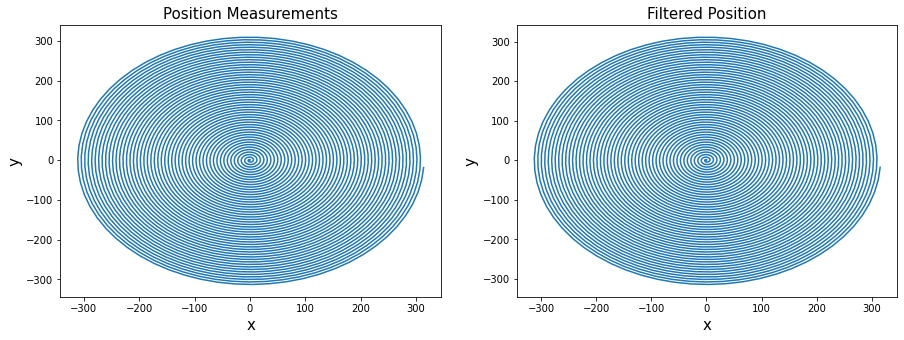

In [57]:
x_fil = []
y_fil = []
for each_state_vec in xs:
    x_fil.append(each_state_vec[0])
    y_fil.append(each_state_vec[3])

plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
plt.plot(xc, yc)
plt.xlabel("x", fontsize=15)
plt.ylabel("y", fontsize=15)
plt.title('Position Measurements', fontsize=15)
plt.subplot(1, 2, 2)
plt.plot(x_fil, y_fil)
plt.xlabel("x", fontsize=15)
plt.ylabel("y", fontsize=15)
plt.title('Filtered Position', fontsize=15)
plt.show()

======================================================================================================

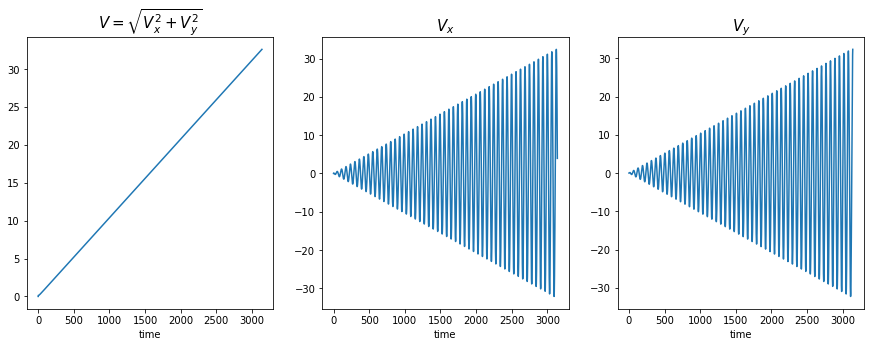

In [58]:
v = []
vx_fil = []
vy_fil = []
for kk in xs:
    vx_fil.append(kk[1])
    vy_fil.append(kk[4])    
    v.append((kk[1]**2 + kk[4]**2)**0.5)
plot_all(v,vx_fil,vy_fil,r"$V = \sqrt{V_x^2 + V_y^2}$",r"$V_x$",r"$V_y$")

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


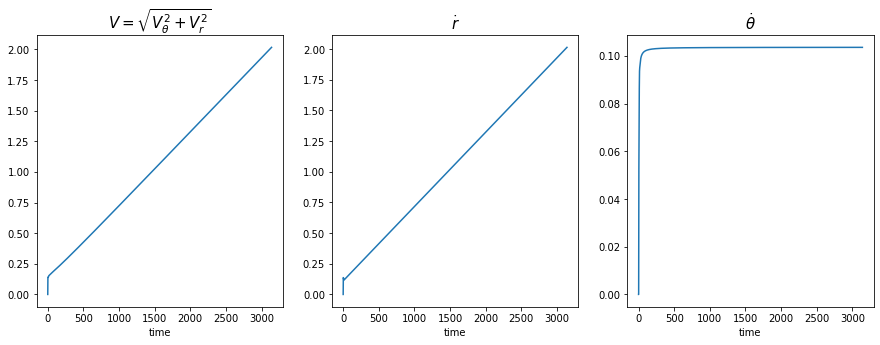

In [73]:
v_pol = []
vθ    = []
vr    = []

for (i,itr) in enumerate(θ):

    trans = np.array([
        [cos(itr),  -r[i]*sin(itr)],
        [sin(itr),   r[i]*cos(itr)]
            ])
    v_vec_cart = np.array([vx_fil[i], vy_fil[i]])
    try :
      v_vec = inv(trans)@v_vec_cart
    except:
      v_vec = [0,0]
    vr.append(v_vec[0])
    vθ.append(v_vec[1])
    v_pol.append((v_vec[0]**2+v_vec[1]**2)**0.5)

plot_all(v_pol, vr, vθ, r"$V = \sqrt{V_\theta^2 + V_r^2}$" , r"$\dot{r}$", r"$\dot{\theta}$")    

In [74]:
np.mean(vθ)

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


array([0.10315944])

===================================================================================================

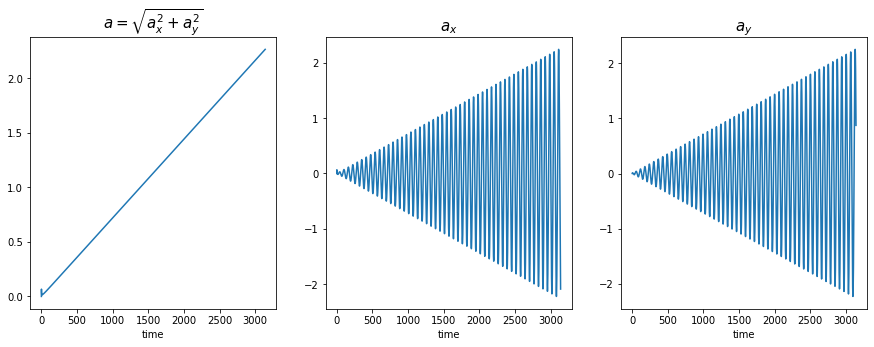

In [61]:
a, ax_fil, ay_fil = [],[],[]
for every_a in xs:
    ax_fil.append(every_a[2])
    ay_fil.append(every_a[5])
    a.append((every_a[2][0]**2 + every_a[5][0]**2)**0.5)

plot_all(a,ax_fil,ay_fil,r"$a = \sqrt{a_x^2 + a_y^2}$",r"$a_x$",r"$a_y$")    

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


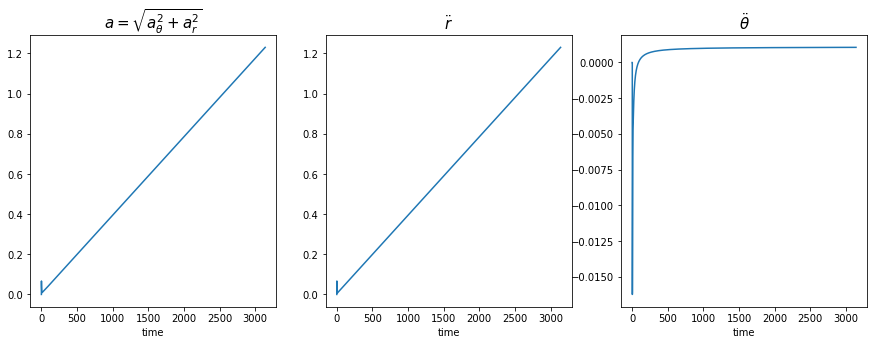

In [72]:
a_pol, aθ, ar = [],[],[]
for (i,itr) in enumerate(θ):

    trans = np.array([
        [cos(itr),             -r[i]*sin(itr)],
        [sin(itr),   r[i]* cos(itr)]
            ])
    a_vec_cart = np.array([ax_fil[i], ay_fil[i]])
    try :
      transf_pol = inv(trans)
    except:
      transf_pol = [0,0]
    
    other_tranf = np.array([

            [-1*sin(itr), -1*cos(itr)],
            [cos(itr) , -1*sin(itr)]                
            
    ])
    dot_vec = np.array([ 2*vr[i]*vθ[i], r[i]*(vθ[i]**2) ])
    pol_matrix =a_vec_cart - other_tranf @ dot_vec
    a_vec = transf_pol @ pol_matrix
    ar.append(a_vec[0])
    aθ.append(a_vec[1])
    a_pol.append((a_vec[0]**2 + a_vec[1]**2)**0.5)
    
plot_all(a_pol,ar,aθ,r"$a = \sqrt{a_\theta^2 + a_r^2}$",r"$\ddot{r}$",r"$\ddot{\theta}$")    

In [71]:
np.mean(aθ[20:])

0.0009343247116611326

np.mean(aθ)

Lets analyze the outcomes. We will be comparing the manoeuvre predictions with the analyticaal solution.

So the spiral trajectory in this example is $r = \theta$ i.e. radius changes in perfect correlation with $\theta$. In our example we have $\dot{\theta}=\small 0.1$ . 

thus $a_r = \ddot{r}-r \dot{\theta}^{2} = -r\times 0.1^2 $. So our prediction of radial accelration should decrease as radius increases and thus time. Also, $a_\theta =  2 \frac{\dot{r} \dot{\theta}}{r}+\ddot{\theta}= 2\times 0.1 \times 0.1 + 0 = 0.02$ which means that tangetial acceleration should be constant. These two key points are evident from plots above.

In [63]:
np.mean(a[5:])

1.1336330408141782

In [75]:
((ar[-1]-ar[0])/len(ar))[0]

0.00039159984062682706